In this notebook, we mainly utilize extreme gradient boost to improve the prediction model originially proposed in TLE 2016 November machine learning tuotrial. Extreme gradient boost can be viewed as an enhanced version of gradient boost by using a more regularized model formalization to control over-fitting, and XGB usually performs better. Applications of XGB can be found in many Kaggle competitions. Some recommended tutorrials can be found

Our work will be orginized in the follwing order:

•Background

•Exploratory Data Analysis

•Data Prepration and Model Selection

•Final Results

# Background

The dataset we will use comes from a class excercise from The University of Kansas on Neural Networks and Fuzzy Systems. This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see Bohling and Dubois (2003) and Dubois et al. (2007).

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core. We will use this log data to train a classifier to predict facies types.

This data is from the Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas. This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector. Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate.

The seven predictor variables are:
•Five wire line log curves include gamma ray (GR), resistivity logging (ILD_log10), photoelectric effect (PE), neutron-density porosity difference and average neutron-density porosity (DeltaPHI and PHIND). Note, some wells do not have PE.
•Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are:

1.Nonmarine sandstone

2.Nonmarine coarse siltstone 

3.Nonmarine fine siltstone 

4.Marine siltstone and shale 

5.Mudstone (limestone)

6.Wackestone (limestone)

7.Dolomite

8.Packstone-grainstone (limestone)

9.Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close. Mislabeling within these neighboring facies can be expected to occur. The following table lists the facies, their abbreviated labels and their approximate neighbors.


Facies/ Label/ Adjacent Facies

1 SS 2 

2 CSiS 1,3 

3 FSiS 2 

4 SiSh 5 

5 MS 4,6 

6 WS 5,7 

7 D 6,8 

8 PS 6,7,9 

9 BS 7,8 


# Exprolatory Data Analysis

After the background intorduction, we start to import the pandas library for some basic data analysis and manipulation. The matplotblib and seaborn are imported for data vislization. 

In [18]:
%matplotlib inline
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors

import xgboost as xgb
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from classification_utilities import display_cm, display_adj_cm
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import validation_curve
from sklearn.datasets import load_svmlight_files
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

seed = 123
np.random.seed(seed)

In [10]:
filename = './facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [6]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
Facies       4149 non-null int64
Formation    4149 non-null category
Well Name    4149 non-null category
Depth        4149 non-null float64
GR           4149 non-null float64
ILD_log10    4149 non-null float64
DeltaPHI     4149 non-null float64
PHIND        4149 non-null float64
PE           3232 non-null float64
NM_M         4149 non-null int64
RELPOS       4149 non-null float64
dtypes: category(2), float64(7), int64(2)
memory usage: 300.1 KB


In [9]:
training_data.describe()

/Users/littleni/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


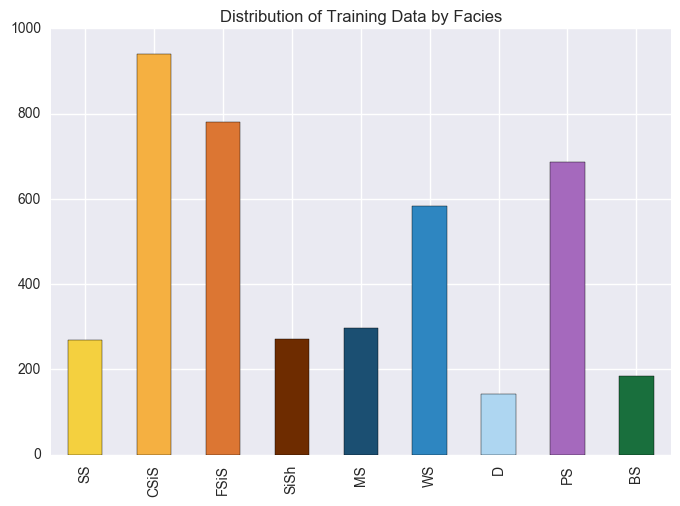

In [7]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72',
                 '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

facies_counts = training_data['Facies'].value_counts().sort_index()
facies_counts.index = facies_labels
facies_counts.plot(kind='bar',color=facies_colors,title='Distribution of Training Data by Facies')

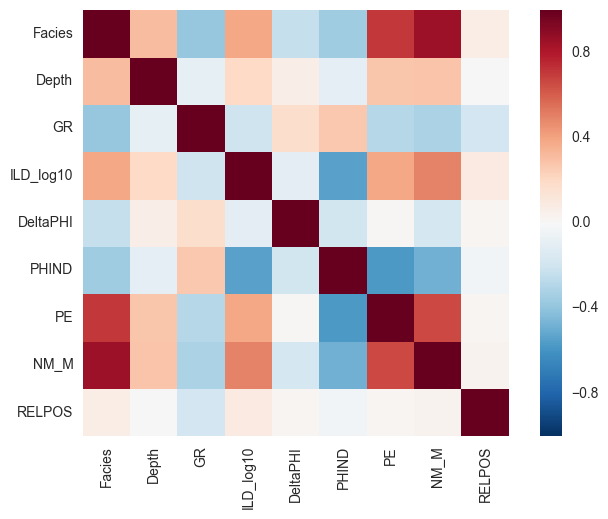

In [8]:
sns.heatmap(training_data.corr(), vmax=1.0, square=True)

# Data Preparation and Model Selection

Now we are ready to test the XGB approach, and will use confusion matrix and f1_score, which were imported, as metric for classification, as well as GridSearchCV, which is an excellent tool for parameter optimization. 

In [11]:
X_train = training_data.drop(['Facies', 'Well Name','Formation','Depth'], axis = 1 ) 
Y_train = training_data['Facies' ] - 1
dtrain = xgb.DMatrix(X_train, Y_train)

In [12]:
train = X_train.copy()

In [13]:
train['Facies']=Y_train

In [14]:
train.head()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,77.45,0.664,9.9,11.915,4.6,1,1.000,2
1,78.26,0.661,14.2,12.565,4.1,1,0.979,2
2,79.05,0.658,14.8,13.050,3.6,1,0.957,2
3,86.10,0.655,13.9,13.115,3.5,1,0.936,2
4,74.58,0.647,13.5,13.300,3.4,1,0.915,2


The accuracy function and accuracy_adjacent function are defined in the following to quatify the prediction correctness. 

In [15]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [16]:
target='Facies'

Before processing further, we define a functin which will help us create XGBoost models and perform cross-validation.

In [20]:
def modelfit(alg, dtrain, features, useTrainCV=True,
             cv_fold=10,early_stopping_rounds = 50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class']=9
        xgtrain = xgb.DMatrix(train[features].values,label = train[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=
                          alg.get_params()['n_estimators'],nfold=cv_fold,
                          metrics='merror',early_stopping_rounds = early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit the algorithm on the data
    alg.fit(dtrain[features], dtrain[target],eval_metric='merror')
        
    #Predict training set:
    dtrain_prediction = alg.predict(dtrain[features])
    dtrain_predprob = alg.predict_proba(dtrain[features])[:,1]
        
    #Pring model report
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(dtrain[target], 
                                            dtrain_prediction))
    print ("F1 score (Train) : %f" % f1_score(dtrain[target], 
                                            dtrain_prediction,average='weighted'))
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar',title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [21]:
features =[x for x in X_train.columns]
features

['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

# General Approach for Parameter Tuning

We are going to preform the steps as follows:

1.Choose a relatively high learning rate, e.g., 0.1. Usually somewhere between 0.05 and 0.3 should work for different problems. 

2.Determine the optimum number of tress for this learning rate.XGBoost has a very usefull function called as "cv" which performs cross-validation at each boosting iteration and thus returns the optimum number of tress required.

3.Tune tree-based parameters(max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. 

4.Tune regularization parameters(lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

5.Lower the learning rate and decide the optimal parameters.

# Step 1:Fix learning rate and number of estimators for tuning tree-based parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

1.max_depth = 5

2.min_child_weight = 1 

3.gamma = 0 

4.subsample, colsample_bytree = 0.8 : This is a commonly used used start value. 

5.scale_pos_weight = 1

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

In [13]:
xgb1 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma = 0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    nthread =4,
    scale_pos_weight=1,
    seed = seed,
)


Model Report
Accuracy : 0.9957
F1 score (Train) : 0.995660


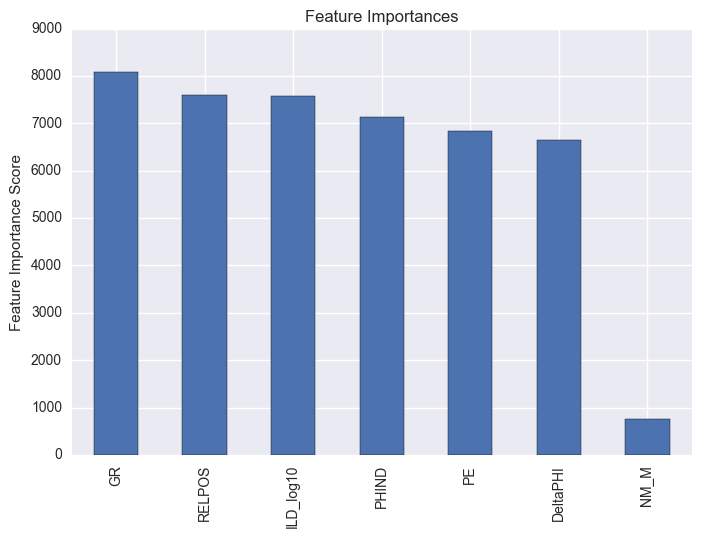

In [14]:
modelfit(xgb1, train, features)

In [15]:
xgb1

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=290, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.8)

# Step 2: Tune max_depth and min_child_weight

In [16]:
param_test1={
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gs1 = GridSearchCV(XGBClassifier(colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, n_estimators=290, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123,subsample=0.8),param_grid=param_test1, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=5)
gs1.fit(train[features],train[target])
gs1.grid_scores_, gs1.best_params_,gs1.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52391, std: 0.06380, params: {'min_child_weight': 1, 'max_depth': 3},
  mean: 0.52272, std: 0.06286, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: 0.52270, std: 0.06329, params: {'min_child_weight': 5, 'max_depth': 3},
  mean: 0.51718, std: 0.06392, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: 0.51838, std: 0.06345, params: {'min_child_weight': 3, 'max_depth': 5},
  mean: 0.51620, std: 0.06891, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: 0.52102, std: 0.07236, params: {'min_child_weight': 1, 'max_depth': 7},
  mean: 0.51668, std: 0.06842, params: {'min_child_weight': 3, 'max_depth': 7},
  mean: 0.51596, std: 0.06904, params: {'min_child_weight': 5, 'max_depth': 7},
  mean: 0.52584, std: 0.06572, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: 0.52271, std: 0.06483, params: {'min_child_weight': 3, 'max_depth': 9},
  mean: 0.51355, std: 0.07046, params: {'min_child_weight': 5, 'max_depth': 9}],
 {'max_depth': 9, 'min_child_weight': 1

In [17]:
param_test2={
    'max_depth':[8,9,10],
    'min_child_weight':[1,2]
}

gs2 = GridSearchCV(XGBClassifier(colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, n_estimators=290, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123,subsample=0.8),param_grid=param_test2, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=5)
gs2.fit(train[features],train[target])
gs2.grid_scores_, gs2.best_params_,gs2.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52391, std: 0.06883, params: {'min_child_weight': 1, 'max_depth': 8},
  mean: 0.52078, std: 0.07002, params: {'min_child_weight': 2, 'max_depth': 8},
  mean: 0.52584, std: 0.06572, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: 0.51621, std: 0.06604, params: {'min_child_weight': 2, 'max_depth': 9},
  mean: 0.52222, std: 0.06617, params: {'min_child_weight': 1, 'max_depth': 10},
  mean: 0.52222, std: 0.06944, params: {'min_child_weight': 2, 'max_depth': 10}],
 {'max_depth': 9, 'min_child_weight': 1},
 0.52584156512733504)

In [18]:
gs2.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=290, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.8)

# Step 3: Tune gamma

In [19]:
param_test3={
   'gamma':[i/10.0 for i in range(0,5)]
}

gs3 = GridSearchCV(XGBClassifier(colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, n_estimators=290, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123,subsample=0.8),param_grid=param_test3, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=5)
gs3.fit(train[features],train[target])
gs3.grid_scores_, gs3.best_params_,gs3.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52584, std: 0.06572, params: {'gamma': 0.0},
  mean: 0.52632, std: 0.07086, params: {'gamma': 0.1},
  mean: 0.52656, std: 0.07059, params: {'gamma': 0.2},
  mean: 0.52633, std: 0.06713, params: {'gamma': 0.3},
  mean: 0.52440, std: 0.06480, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 0.52655662535367609)


Model Report
Accuracy : 0.9978
F1 score (Train) : 0.997830


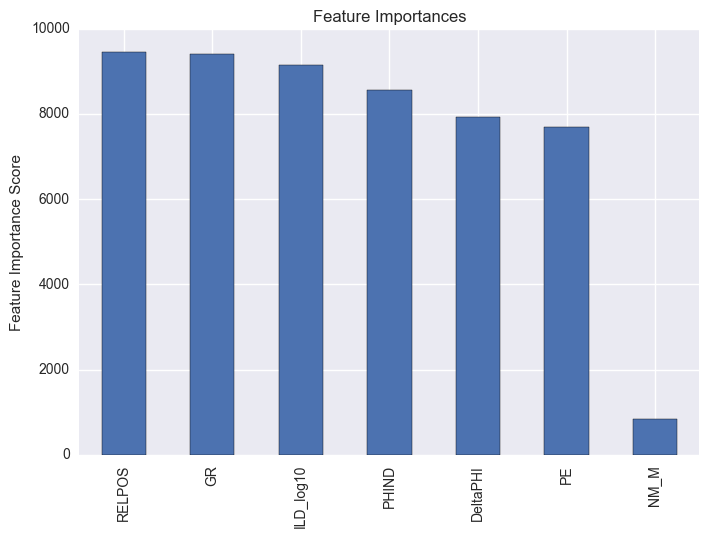

In [20]:
xgb2 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=1,
    gamma = 0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    nthread =4,
    scale_pos_weight=1,
    seed = seed,
)
modelfit(xgb2,train,features)

In [21]:
xgb2

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=236, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.8)

# Step 4:Tune subsample and colsample_bytree

In [22]:
param_test4={
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gs4 = GridSearchCV(XGBClassifier(colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, n_estimators=236, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123,subsample=0.8),param_grid=param_test4, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=5)
gs4.fit(train[features],train[target])
gs4.grid_scores_, gs4.best_params_,gs4.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52222, std: 0.07060, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.52392, std: 0.06317, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.52994, std: 0.06877, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.52704, std: 0.06807, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.52222, std: 0.07060, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.52392, std: 0.06317, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.52994, std: 0.06877, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.52704, std: 0.06807, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.53162, std: 0.07243, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.52705, std: 0.07100, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.52608, std: 0.07036, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.51885, std: 0.06818, params: {'colsample_bytree': 0.8, 'subsample'

In [23]:
param_test4b={
    'subsample':[i/10.0 for i in range(5,7)],
}

gs4b = GridSearchCV(XGBClassifier(colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, n_estimators=236, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123,subsample=0.8),param_grid=param_test4b, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=5)
gs4b.fit(train[features],train[target])
gs4b.grid_scores_, gs4b.best_params_,gs4b.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52414, std: 0.06889, params: {'subsample': 0.5},
  mean: 0.53162, std: 0.07243, params: {'subsample': 0.6}],
 {'subsample': 0.6},
 0.53161835175244798)

# Step 5: Tuning Regularization Parameters

In [24]:
param_test5={
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gs5 = GridSearchCV(XGBClassifier(colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, n_estimators=236, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123,subsample=0.6),param_grid=param_test5, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=5)
gs5.fit(train[features],train[target])
gs5.grid_scores_, gs5.best_params_,gs5.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52825, std: 0.07059, params: {'reg_alpha': 1e-05},
  mean: 0.52513, std: 0.07066, params: {'reg_alpha': 0.01},
  mean: 0.52800, std: 0.07177, params: {'reg_alpha': 0.1},
  mean: 0.52462, std: 0.07812, params: {'reg_alpha': 1},
  mean: 0.47094, std: 0.03632, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.52825352135380199)

In [25]:
param_test6={
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gs6 = GridSearchCV(XGBClassifier(colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, n_estimators=236, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=123,subsample=0.6),param_grid=param_test6, 
                   scoring='accuracy', n_jobs=4,iid=False, cv=5)
gs6.fit(train[features],train[target])
gs6.grid_scores_, gs6.best_params_,gs6.best_score_

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.53162, std: 0.07243, params: {'reg_alpha': 0},
  mean: 0.52968, std: 0.07384, params: {'reg_alpha': 0.001},
  mean: 0.52921, std: 0.07140, params: {'reg_alpha': 0.005},
  mean: 0.52513, std: 0.07066, params: {'reg_alpha': 0.01},
  mean: 0.53186, std: 0.07231, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.05},
 0.53185612242083324)


Model Report
Accuracy : 0.9966
F1 score (Train) : 0.996622


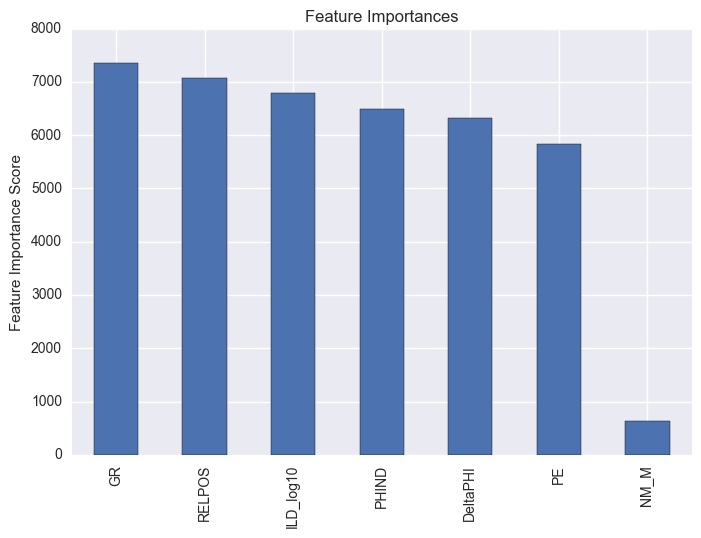

In [26]:
xgb3 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=1,
    gamma = 0.2,
    subsample=0.6,
    colsample_bytree=0.8,
    reg_alpha=0.05,
    objective='multi:softmax',
    nthread =4,
    scale_pos_weight=1,
    seed = seed,
)
modelfit(xgb3,train,features)

In [27]:
xgb3

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=122, nthread=4,
       objective='multi:softprob', reg_alpha=0.05, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.6)

# Step 6: Reducing Learning Rate


Model Report
Accuracy : 0.9467
F1 score (Train) : 0.946662


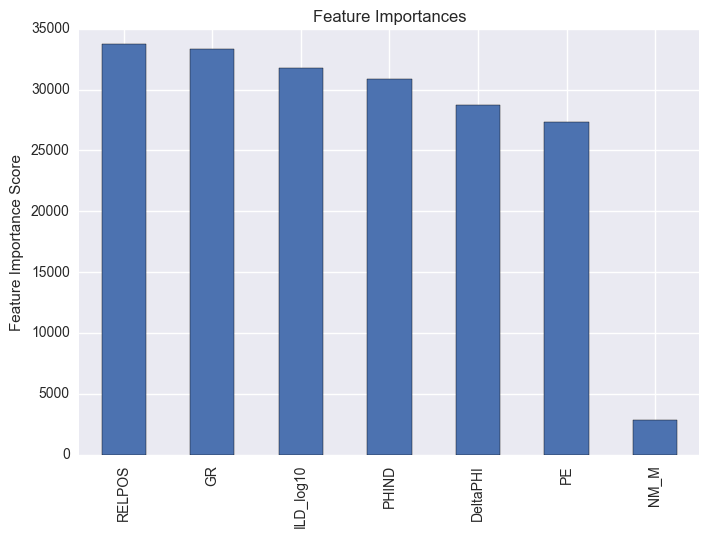

In [28]:
xgb4 = XGBClassifier(
    learning_rate = 0.01,
    n_estimators=5000,
    max_depth=9,
    min_child_weight=1,
    gamma = 0.2,
    subsample=0.6,
    colsample_bytree=0.8,
    reg_alpha=0.05,
    objective='multi:softmax',
    nthread =4,
    scale_pos_weight=1,
    seed = seed,
)
modelfit(xgb4,train,features)

In [29]:
xgb4

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.01, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=432, nthread=4,
       objective='multi:softprob', reg_alpha=0.05, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.6)

Next we use our tuned final model to do cross validation on the training data set. One of the wells will be used as test data and the rest will be the training data. Each iteration, a different well is chosen.

In [23]:
# Load data 
filename = './facies_vectors.csv'
data = pd.read_csv(filename)

# Change to category data type
data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')

# Leave one well out for cross validation 
well_names = data['Well Name'].unique()
f1=[]
for i in range(len(well_names)):
    
    # Split data for training and testing
    X_train = data.drop(['Facies', 'Formation','Depth'], axis = 1 ) 
    Y_train = data['Facies' ] - 1
    
    train_X = X_train[X_train['Well Name'] != well_names[i] ]
    train_Y = Y_train[X_train['Well Name'] != well_names[i] ]
    test_X  = X_train[X_train['Well Name'] == well_names[i] ]
    test_Y  = Y_train[X_train['Well Name'] == well_names[i] ]

    train_X = train_X.drop(['Well Name'], axis = 1 ) 
    test_X = test_X.drop(['Well Name'], axis = 1 )

    # Final recommended model based on the extensive parameters search
    model_final = XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.2,
       learning_rate=0.01, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=432, nthread=4,
       objective='multi:softmax', reg_alpha=0.05, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=1,
       subsample=0.6)
    # Train the model based on training data
    model_final.fit( train_X , train_Y , eval_metric = 'merror' )


    # Predict on the test set
    predictions = model_final.predict(test_X)

    # Print report
    print ("\n------------------------------------------------------")
    print ("Validation on the leaving out well " + well_names[i])
    conf = confusion_matrix( test_Y, predictions, labels = np.arange(9) )
    print ("\nModel Report")
    print ("-Accuracy: %.6f" % ( accuracy(conf) ))
    print ("-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) ))
    print ("-F1 Score: %.6f" % ( f1_score ( test_Y , predictions , labels = np.arange(9), average = 'weighted' ) ))
    f1.append(f1_score ( test_Y , predictions , labels = np.arange(9), average = 'weighted' ))
    facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                     'WS', 'D','PS', 'BS']
    print ("\nConfusion Matrix Results")
    from classification_utilities import display_cm, display_adj_cm
    display_cm(conf, facies_labels,display_metrics=True, hide_zeros=True)
    
print ("\n------------------------------------------------------")
print ("Final Results")
print ("-Average F1 Score: %6f" % (sum(f1)/(1.0*len(f1))))


------------------------------------------------------
Validation on the leaving out well SHRIMPLIN

Model Report
-Accuracy: 0.598726
-Adjacent Accuracy: 0.949045
-F1 Score: 0.575205

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS     1    94    23                                       118
     FSiS     1    52    70                                       123
     SiSh                      12           2           4          18
       MS                       7     8    38          10          63
       WS                       4     1    33     2    21     2    63
        D                                               5           5
       PS                             1     9          53     6    69
       BS                                                    12    12

Precision  0.00  0.64  0.75  0.52  0.80  0.40  0.00  0.57  0.60  0.64
   Recall

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Validation on the leaving out well ALEXANDER D

Model Report
-Accuracy: 0.639485
-Adjacent Accuracy: 0.914163
-F1 Score: 0.604408

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS          86    31                                       117
     FSiS          16    75                                        91
     SiSh                      37           2     3     2          44
       MS                       3    13     1           9          26
       WS                      12    20     1     9    27          69
        D                             2           9     5          16
       PS                       6     4     4     9    72     3    98
       BS                                                     5     5

Precision  0.00  0.84  0.71  0.64  0.33  0.12  0.30  0.63  0.62  0.60
   Reca

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Validation on the leaving out well SHANKLE

Model Report
-Accuracy: 0.512249
-Adjacent Accuracy: 0.966592
-F1 Score: 0.487142

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     6    83                                              89
     CSiS     7    71    11                                        89
     FSiS          45    71                             1         117
     SiSh                       1           5           1           7
       MS                      12     1     4     1     1          19
       WS                 2     4     5    47          13          71
        D                                   1    12     4          17
       PS                                  18     1    21          40
       BS                                                           0

Precision  0.46  0.36  0.85  0.06  0.17  0.63  0.86  0.51  0.00  0.57
   Recall  

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Validation on the leaving out well LUKE G U

Model Report
-Accuracy: 0.620390
-Adjacent Accuracy: 0.941432
-F1 Score: 0.647271

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS    15    85    17                                       117
     FSiS     4    45    76                             4         129
     SiSh                      29     3     3                      35
       MS                             1                 1           2
       WS                       7    21    42          12     2    84
        D                                   2     7    11          20
       PS                 2     2     2    20     2    46          74
       BS                                                           0

Precision  0.00  0.65  0.80  0.76  0.04  0.63  0.78  0.62  0.00  0.70
   Recall 

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Validation on the leaving out well KIMZEY A

Model Report
-Accuracy: 0.517084
-Adjacent Accuracy: 0.886105
-F1 Score: 0.482987

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS           5     4                                         9
     CSiS          72    13                                        85
     FSiS          40    34                                        74
     SiSh                      23     3    17                      43
       MS                       5          33          13     2    53
       WS                 1     3          26     2    17     2    51
        D                       4           6     6    10     1    27
       PS                       1     1    23     4    60     1    90
       BS                                   1                 6     7

Precision  0.00  0.62  0.65  0.64  0.00  0.25  0.50  0.60  0.50  0.48
   Recall 

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



------------------------------------------------------
Validation on the leaving out well CROSS H CATTLE

Model Report
-Accuracy: 0.385230
-Adjacent Accuracy: 0.882236
-F1 Score: 0.370080

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    33   109    16                                       158
     CSiS     2    63    76                             1         142
     FSiS           5    39                 1           2          47
     SiSh                 4     4     2    14           1          25
       MS           4     3           1    16     1     3          28
       WS                       1          23     1     6          31
        D                                         1     1           2
       PS                 4     3     1    26     5    29          68
       BS                                                           0

Precision  0.94  0.35  0.27  0.50  0.25  0.29  0.12  0.67  0.00  0.57
   R

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Validation on the leaving out well NOLAN

Model Report
-Accuracy: 0.513253
-Adjacent Accuracy: 0.860241
-F1 Score: 0.538718

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS           4                                               4
     CSiS    16    83    18                             1         118
     FSiS     5    20    40                 1           2          68
     SiSh           1           8     2    13     1     3          28
       MS           3                 3    27     2     9     3    47
       WS     1                 1          10          15     3    30
        D                       1                 2     1           4
       PS                 5     3          16     3    67    22   116
       BS                                                           0

Precision  0.00  0.75  0.63  0.62  0.60  0.15  0.25  0.68  0.00  0.63
   Recall  0.

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Validation on the leaving out well Recruit F9

Model Report
-Accuracy: 0.825000
-Adjacent Accuracy: 0.975000
-F1 Score: 0.904110

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS                                                           0
     FSiS                                                           0
     SiSh                                                           0
       MS                                                           0
       WS                                                           0
        D                                                           0
       PS                                                           0
       BS                                   2     2    10    66    80

Precision  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  1.00
   Recal

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Validation on the leaving out well NEWBY

Model Report
-Accuracy: 0.477322
-Adjacent Accuracy: 0.896328
-F1 Score: 0.474133

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                                           0
     CSiS    16    55    25                             2          98
     FSiS     1    34    44                             1          80
     SiSh                      35     4    11     4     4          58
       MS                 4     2          11     4     7          28
       WS                       2    16    34     3    41          96
        D                                   2     6     8          16
       PS                             3     7          46          56
       BS                       1           4          25     1    31

Precision  0.00  0.62  0.60  0.88  0.00  0.49  0.35  0.34  1.00  0.57
   Recall  0.

/Users/littleni/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



------------------------------------------------------
Validation on the leaving out well CHURCHMAN BIBLE

Model Report
-Accuracy: 0.586634
-Adjacent Accuracy: 0.888614
-F1 Score: 0.557692

Confusion Matrix Results
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS           7     1                                         8
     CSiS     4    31    20                 1                      56
     FSiS           9    37     2     1     1           1          51
     SiSh                       6     1     6                      13
       MS                 1     2     3    20           4          30
       WS                      12     1    64          10          87
        D                 1           1     3     3    23     3    34
       PS                 3     2     5    22          43          75
       BS                                                    50    50

Precision  0.00  0.66  0.59  0.25  0.25  0.55  1.00  0.53  0.94  0.61
   

Use final model to predict the given test data set

In [24]:
# Load test data
test_data = pd.read_csv('validation_data_nofacies.csv')
test_data['Well Name'] = test_data['Well Name'].astype('category')
X_test = test_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
# Predict facies of unclassified data
Y_predicted = model_final.predict(X_test)
test_data['Facies'] = Y_predicted + 1
# Store the prediction
test_data.to_csv('Prediction2.csv')

In [25]:
test_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,2
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,2
5,A1 SH,STUART,2810.5,73.955,0.667,6.900,12.250,3.086,1,0.889,2
6,A1 SH,STUART,2811.0,77.962,0.674,6.500,12.450,3.092,1,0.867,2
7,A1 SH,STUART,2811.5,83.894,0.667,6.300,12.650,3.123,1,0.844,2
8,A1 SH,STUART,2812.0,84.424,0.653,6.700,13.050,3.121,1,0.822,2
9,A1 SH,STUART,2812.5,83.160,0.642,7.300,12.950,3.127,1,0.800,2


Future work, make more customerized objective function. Also, we could use RandomizedSearchCV instead of GridSearchCV to avoild potential local minimal trap and further improve the test results. 